In [1]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
from datasets import load_dataset

# Loads train/validation/test splits with translation field
dataset = load_dataset("agentlans/en-fr")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.72k [00:00<?, ?B/s]

train.jsonl.zst:   0%|          | 0.00/149M [00:00<?, ?B/s]

test.jsonl.zst:   0%|          | 0.00/37.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1686856 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/421715 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 1686856
    })
    test: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 421715
    })
})


In [3]:
small_train = dataset["train"].shuffle(seed=42).select(range(14_000))
small_test = dataset["test"].shuffle(seed=42).select(range(4_000))

In [4]:
small_dataset = {
    "train": small_train,
    "test": small_test
}

In [5]:
print(small_dataset["train"][0])
print(len(small_dataset["train"]))
print(len(small_dataset["test"]))

{'id': 526884, 'english': 'The project will also involve extensive demonstration carried out within the framework of TEN-TELECOM, which provides a series of guidelines for developing trans-European telecommunications networks.', 'french': "Le projet fera également appel à d'importantes activités de démonstration menées dans le cadre de RTE-TELECOM, qui fournit un ensemble d'orientations pour le développement des réseaux transeuropéens de télécommunications.", 'source': 'ELRC-1118-CORDIS_News', 'translation_quality': 0.8736, 'readability_grade': 19.24}
14000
4000


In [6]:
split_2=small_dataset['test'].train_test_split(test_size=0.5,seed=42)

validation_dataset=split_2["train"]

test_dataset=split_2["test"]

print(f"Length of the validation dataset: {len(validation_dataset)}")

print(f"Length of the test dataset: {len(test_dataset)}")

Length of the validation dataset: 2000
Length of the test dataset: 2000


In [7]:
train_dataset=small_dataset["train"]
print(train_dataset)

Dataset({
    features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
    num_rows: 14000
})


In [8]:
from datasets import DatasetDict

final_dataset=DatasetDict({
    "train":train_dataset,
    "validation":validation_dataset,
    "test":test_dataset
})

print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 14000
    })
    validation: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['id', 'english', 'french', 'source', 'translation_quality', 'readability_grade'],
        num_rows: 2000
    })
})


In [9]:
##converting to csv for flexible usage

train_dataset=final_dataset["train"].to_pandas()

validation_dataset=final_dataset["validation"].to_pandas()

test_dataset=final_dataset["test"].to_pandas()

In [10]:
train_dataset.drop(['id','source','translation_quality','readability_grade'],axis=1,inplace=True)

validation_dataset.drop(['id','source','translation_quality','readability_grade'],axis=1,inplace=True)

test_dataset.drop(['id','source','translation_quality','readability_grade'],axis=1,inplace=True)

In [11]:
train_dataset.columns=['en','fr']

validation_dataset.columns=['en','fr']

test_dataset.columns=['en','fr']

In [12]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 33.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import spacy

# Load SpaCy tokenizers
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_sm")

In [14]:
def tokenize_spacy(text, nlp):
    return [token.text for token in nlp(text.strip()) if not token.is_space]

In [15]:
from collections import Counter

def build_vocab_spacy(sentences, nlp, min_freq=1):
    counter = Counter()
    for sentence in sentences:
        tokens = tokenize_spacy(sentence, nlp)
        counter.update(tokens)

    vocab = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>": 3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

In [16]:
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn

In [17]:
en_vocab = build_vocab_spacy(train_dataset["en"], nlp_en)
fr_vocab = build_vocab_spacy(train_dataset["fr"], nlp_fr)

In [18]:
MAX_LEN = 100

def encode_spacy(sentence, vocab, nlp, max_len=MAX_LEN):
    tokens = ["<sos>"] + tokenize_spacy(sentence, nlp) + ["<eos>"]
    token_ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    token_ids = token_ids[:max_len]
    token_ids += [vocab["<pad>"]] * (max_len - len(token_ids))
    return token_ids

In [19]:
# Train Set
train_dataset["input_ids_en"] = train_dataset["en"].apply(lambda x: encode_spacy(x, en_vocab, nlp_en))
train_dataset["input_ids_fr"] = train_dataset["fr"].apply(lambda x: encode_spacy(x, fr_vocab, nlp_fr))

# Validation Set
validation_dataset["input_ids_en"] = validation_dataset["en"].apply(lambda x: encode_spacy(x, en_vocab, nlp_en))
validation_dataset["input_ids_fr"] = validation_dataset["fr"].apply(lambda x: encode_spacy(x, fr_vocab, nlp_fr))

# Test Set
test_dataset["input_ids_en"] = test_dataset["en"].apply(lambda x: encode_spacy(x, en_vocab, nlp_en))
test_dataset["input_ids_fr"] = test_dataset["fr"].apply(lambda x: encode_spacy(x, fr_vocab, nlp_fr))


In [20]:
class TranslationDataset(Dataset):
    def __init__(self, encoded_en, encoded_fr):
        self.en_data = encoded_en
        self.fr_data = encoded_fr

    def __len__(self):
        return len(self.en_data)

    def __getitem__(self, idx):
        return {
            "input_ids_en": torch.tensor(self.en_data[idx], dtype=torch.long),
            "input_ids_fr": torch.tensor(self.fr_data[idx], dtype=torch.long)
        }


In [21]:
"""Okay-system calculations very important-utilizing the GPU"""
import torch

device='cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [22]:
"""Generating iterators for the dataloader that would load the data in batches whilst training, first lets just create a cutom dataset from the encoded_train
(tokenized pre-processed dataset)"""

train_dataset_pt = TranslationDataset(
    train_dataset["input_ids_en"].tolist(),
    train_dataset["input_ids_fr"].tolist()
)

train_loader = DataLoader(train_dataset_pt, batch_size=4, shuffle=True,num_workers=2,pin_memory='cuda')


In [23]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_layers=2, embed_dim=768, pad_token_id=0):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_token_id
        )

        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embed_dim)
        output, _ = self.bilstm(embedded)     # output: (batch_size, seq_len, hidden_dim*2)
        return output  # Return all time-step outputs for attention


In [24]:
class BridgeLayer(nn.Module):
    def __init__(self, encoder_output_dim, decoder_hidden_dim, num_layers=2):
        super().__init__()
        self.hidden_fc = nn.Linear(encoder_output_dim, decoder_hidden_dim)
        self.cell_fc = nn.Linear(encoder_output_dim, decoder_hidden_dim)
        self.num_layers = num_layers

    def forward(self, encoder_outputs):
        # encoder_outputs: (batch, seq_len, hidden_dim * 2)
        pooled = encoder_outputs.mean(dim=1)  # mean over time steps → (batch, encoder_output_dim)

        h_0_single = self.hidden_fc(pooled).unsqueeze(0)  # (1, batch, hidden_dim)
        c_0_single = self.cell_fc(pooled).unsqueeze(0)

        h_0 = h_0_single.repeat(self.num_layers, 1, 1)  # (num_layers, batch, hidden_dim)
        c_0 = c_0_single.repeat(self.num_layers, 1, 1)
        return h_0, c_0


In [25]:
class LuongAttentionDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, pad_token_id, bos_token_id, eos_token_id,
                 num_layers=2, max_len=90, embed_dim=768, device='cuda'):
        super().__init__()

        self.device = device
        self.vocab_size = output_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.vocab_size, self.embed_dim, padding_idx=pad_token_id)

        self.lstm = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )

        self.attn = nn.Linear(hidden_dim, hidden_dim * 2)
        self.context_combine = nn.Linear(hidden_dim + hidden_dim * 2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.pad_token_id = pad_token_id
        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id

    def _compute_attention(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (batch, hidden_dim)
        # encoder_outputs: (batch, src_len, hidden_dim*2)
        attn_scores = torch.bmm(encoder_outputs, self.attn(decoder_hidden).unsqueeze(2)).squeeze(2)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, src_len)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch, hidden_dim*2)
        return context

    def forward(self, input_ids_decoder, encoder_outputs, h_0, c_0):
        embeddings = self.embedding(input_ids_decoder)  # (batch, tgt_len, embed_dim)
        outputs = []
        hidden, cell = h_0, c_0

        for t in range(embeddings.size(1)):
            emb_t = embeddings[:, t:t+1, :]  # (batch, 1, embed_dim)
            lstm_out, (hidden, cell) = self.lstm(emb_t, (hidden, cell))
            dec_hidden = lstm_out[:, -1, :]  # (batch, hidden_dim)

            context = self._compute_attention(dec_hidden, encoder_outputs)  # (batch, hidden_dim*2)

            combined = torch.cat((dec_hidden, context), dim=1)  # (batch, hidden_dim + hidden_dim*2)
            out = torch.tanh(self.context_combine(combined))    # (batch, hidden_dim)
            logits = self.fc_out(out)  # (batch, vocab_size)

            outputs.append(logits.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # (batch, tgt_len, vocab)

    def generate(self, encoder_outputs, h_0, c_0):
        batch_size = encoder_outputs.size(0)
        generated_ids = torch.full((batch_size, 1), self.bos_token_id, dtype=torch.long).to(self.device)
        hidden, cell = h_0, c_0

        for _ in range(self.max_len):
            emb = self.embedding(generated_ids[:, -1:])  # (batch, 1, embed_dim)
            lstm_out, (hidden, cell) = self.lstm(emb, (hidden, cell))
            dec_hidden = lstm_out[:, -1, :]  # (batch, hidden_dim)

            context = self._compute_attention(dec_hidden, encoder_outputs)
            combined = torch.cat((dec_hidden, context), dim=1)
            out = torch.tanh(self.context_combine(combined))
            logits = self.fc_out(out)

            next_token_id = torch.argmax(logits, dim=-1).unsqueeze(1)
            generated_ids = torch.cat((generated_ids, next_token_id), dim=1)

            if (next_token_id == self.eos_token_id).all():
                break

        return generated_ids[:, 1:]  # Remove <bos>


In [26]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

# Models
encoder_model = Encoder(
    vocab_size=len(en_vocab),
    hidden_dim=512,
    num_layers=2,
    embed_dim=768,
    pad_token_id=en_vocab["<pad>"]
).to(device)

bridge_layer = BridgeLayer(
    encoder_output_dim=1024,
    decoder_hidden_dim=512,
    num_layers=2
).to(device)

decoder_model = LuongAttentionDecoder(
    hidden_dim=512,
    output_dim=len(fr_vocab),
    pad_token_id=fr_vocab["<pad>"],
    bos_token_id=fr_vocab["<sos>"],
    eos_token_id=fr_vocab["<eos>"],
    embed_dim=768,
    num_layers=2,
    max_len=90,
    device=device
).to(device)

# Optimizer & Loss
params = list(encoder_model.parameters()) + \
         list(bridge_layer.parameters()) + \
         list(decoder_model.parameters())

optimizer = torch.optim.Adam(params, lr=0.0003)
criterion = nn.CrossEntropyLoss(ignore_index=fr_vocab["<pad>"])

# Training
epochs = 12
losses = []

for epoch in range(epochs):
    encoder_model.train()
    bridge_layer.train()
    decoder_model.train()

    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids_en = batch["input_ids_en"].to(device)
        input_ids_fr = batch["input_ids_fr"].to(device)

        optimizer.zero_grad()

        # Encode input
        encoder_outputs = encoder_model(input_ids_en)   # (batch, src_len, 1024)

        #Bridge to decoder initial states
        h_0, c_0 = bridge_layer(encoder_outputs)        # (num_layers, batch, 512)

        #Decode with attention
        decoder_out = decoder_model(input_ids_fr, encoder_outputs, h_0, c_0)  # (batch, tgt_len, vocab)

        # Shift targets
        target_ids = input_ids_fr[:, 1:]            # remove <sos>
        predicted_logits = decoder_out[:, :-1, :]   # shift predictions to align

        loss = criterion(
            predicted_logits.reshape(-1, predicted_logits.size(-1)),
            target_ids.reshape(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

100%|██████████| 3500/3500 [22:29<00:00,  2.59it/s]


Epoch 1 - Avg Loss: 6.2328


100%|██████████| 3500/3500 [22:26<00:00,  2.60it/s]


Epoch 2 - Avg Loss: 5.1377


100%|██████████| 3500/3500 [22:29<00:00,  2.59it/s]


Epoch 3 - Avg Loss: 4.6383


100%|██████████| 3500/3500 [22:27<00:00,  2.60it/s]


Epoch 4 - Avg Loss: 4.1622


100%|██████████| 3500/3500 [22:26<00:00,  2.60it/s]


Epoch 5 - Avg Loss: 3.6710


100%|██████████| 3500/3500 [22:23<00:00,  2.60it/s]


Epoch 6 - Avg Loss: 3.1678


100%|██████████| 3500/3500 [22:23<00:00,  2.61it/s]


Epoch 7 - Avg Loss: 2.6725


100%|██████████| 3500/3500 [22:24<00:00,  2.60it/s]


Epoch 8 - Avg Loss: 2.1936


100%|██████████| 3500/3500 [22:26<00:00,  2.60it/s]


Epoch 9 - Avg Loss: 1.7520


100%|██████████| 3500/3500 [22:26<00:00,  2.60it/s]

Epoch 10 - Avg Loss: 1.3517


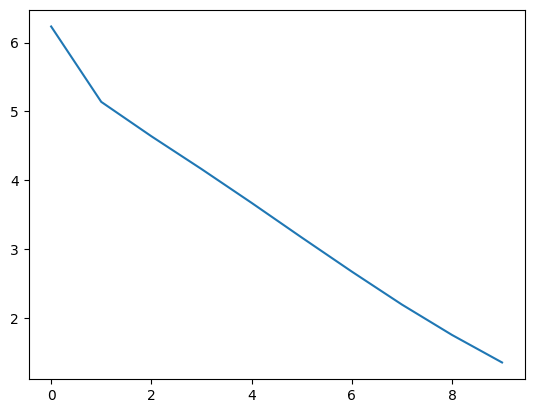

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(10),losses)
plt.show()

In [34]:
val_dataset_pt = TranslationDataset(
    validation_dataset["input_ids_en"].tolist(),
    validation_dataset["input_ids_fr"].tolist()
)

test_dataset_pt = TranslationDataset(
    test_dataset["input_ids_en"].tolist(),
    test_dataset["input_ids_fr"].tolist()
)

In [35]:
val_loader = DataLoader(val_dataset_pt, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset_pt, batch_size=2, shuffle=False)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

def decode_sentence(token_ids, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    tokens = []
    for token_id in token_ids:
        token = inv_vocab.get(token_id.item(), "<unk>")
        if token in ["<pad>", "<sos>"]:
            continue
        if token == "<eos>":
            break
        tokens.append(token)
    return tokens

def evaluate_bleu(encoder_model, bridge_layer, decoder_model, dataloader, en_vocab, fr_vocab, device):
    encoder_model.eval()
    bridge_layer.eval()
    decoder_model.eval()

    references = []
    hypotheses = []

    smoothie = SmoothingFunction().method4  # BLEU smoothing

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids_en = batch["input_ids_en"].to(device)
            input_ids_fr = batch["input_ids_fr"].to(device)

            #Encoder returns all hidden states (for attention)
            encoder_outputs = encoder_model(input_ids_en)  # (batch, src_len, hidden*2)

            # Bridge layer initializes decoder hidden/cell states
            h_0, c_0 = bridge_layer(encoder_outputs)  # (num_layers, batch, hidden)

            # Decoder now needs encoder_outputs for attention
            generated_ids = decoder_model.generate(encoder_outputs, h_0, c_0)

            for gen, tgt in zip(generated_ids, input_ids_fr):
                pred_tokens = decode_sentence(gen, fr_vocab)
                tgt_tokens = decode_sentence(tgt, fr_vocab)

                hypotheses.append(pred_tokens)
                references.append([tgt_tokens])

    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    return bleu_score


In [36]:
val_bleu = evaluate_bleu(
    encoder_model,
    bridge_layer,
    decoder_model,
    val_loader,
    en_vocab,
    fr_vocab,
    device
)
print(f"Validation BLEU Score: {val_bleu:.4f}")

test_bleu = evaluate_bleu(
    encoder_model,
    bridge_layer,
    decoder_model,
    test_loader,
    en_vocab,
    fr_vocab,
    device
)
print(f"Test BLEU Score: {test_bleu:.4f}")


100%|██████████| 1000/1000 [01:15<00:00, 13.30it/s]


Validation BLEU Score: 0.0209


100%|██████████| 1000/1000 [01:13<00:00, 13.53it/s]


Test BLEU Score: 0.0201
